<a href="https://colab.research.google.com/github/vinceriot/computervision/blob/main/LR_3_Residual_Connection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Голдобин Денис ФИТ-1-21

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
download_dir = "./dataset"

In [ ]:
# Трансформации для нормализации данных.
transform = transforms.Compose([transforms.ToTensor()])

# Скачиваем обучающую выборку FashionMNIST.
train_data = datasets.FashionMNIST(root=download_dir, download=True, train=True, transform=transform)

# Скачиваем валидационную выборку FashionMNIST.
val_data = datasets.FashionMNIST(root=download_dir, download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 11114729.19it/s]


Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211443.14it/s]


Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 643099.29it/s] 


Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7479139.93it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



In [ ]:
# Объекты данных из обучающей выборки.
x_train = torch.stack([train_data[i][0] for i in range(len(train_data))])
y_train = torch.tensor([train_data[i][1] for i in range(len(train_data))])

print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])


In [ ]:
# Сопоставление численных значений реальным классам.
classes = train_data.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# Аналогично записываем x и y для валидационной выборки.
x_val = torch.stack([val_data[i][0] for i in range(len(val_data))])
y_val = torch.tensor([val_data[i][1] for i in range(len(val_data))])

print(x_val.shape)  # [10000, 1, 28, 28]
print(y_val.shape)  # [10000]


torch.Size([10000, 1, 28, 28])
torch.Size([10000])


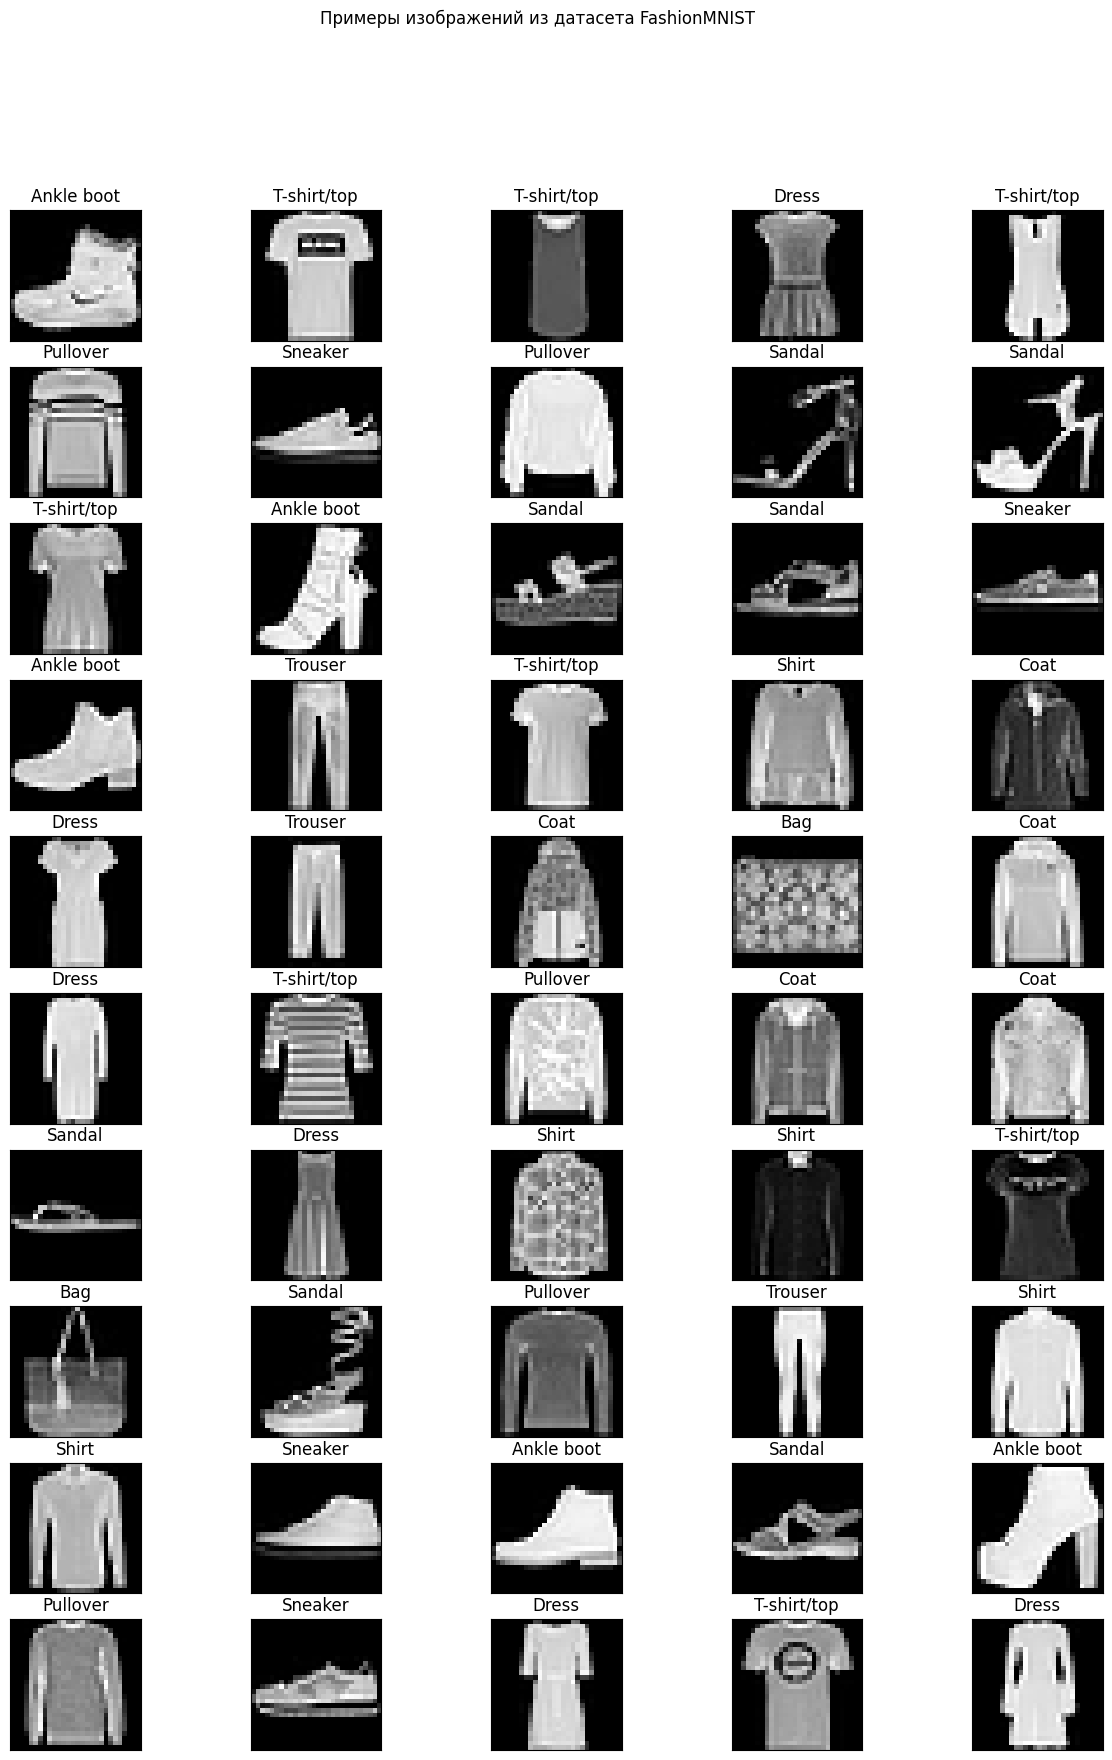

In [ ]:
# Посмотрим на то, как выглядят картинки из датасета FashionMNIST.
import matplotlib.pyplot as plt

hh = 10
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(15, 20))
fig.suptitle("Примеры изображений из датасета FashionMNIST")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    img = x.squeeze(0).numpy()  # Убираем лишний канал.
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[y.item()])

plt.show()

In [ ]:
# Проверяем, что у нас вещественные числа.
print(x_train.min(), x_train.max(), x_train.dtype)

tensor(0.) tensor(1.) torch.float32


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output


In [ ]:
# Определяем класс модели с остаточными блоками для FashionMNIST (1 канал).
class ResidualBlock(nn.Module):
    def __init__(self, input_c, output_c, kernel_size, activation=nn.ReLU, padding_mode='zeros'):
        super().__init__()
        self.activation = activation()
        padding_size = kernel_size // 2
        self.conv = nn.Conv2d(in_channels=input_c, out_channels=output_c, kernel_size=kernel_size,
                              padding=padding_size, padding_mode=padding_mode)
        if input_c != output_c:
            self.correct_channels = nn.Conv2d(in_channels=input_c, out_channels=output_c, kernel_size=1, padding=0)
        else:
            self.correct_channels = nn.Identity()

    def forward(self, x):
        return self.activation(self.conv(x) + self.correct_channels(x))


In [ ]:
class LeNet5Residual(nn.Module):
    def __init__(self):
        super(LeNet5Residual, self).__init__()
        self.res_block1 = ResidualBlock(input_c=1, output_c=32, kernel_size=5)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # После этого выход 32x14x14
        self.res_block2 = ResidualBlock(input_c=32, output_c=64, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # После этого выход 64x7x7
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 120)  # Меняем на 64*7*7 = 3136
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)  # В FashionMNIST 10 классов

    def forward(self, x):
        x = self.res_block1(x)
        x = self.pool1(x)
        x = self.res_block2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x


In [ ]:
# Подготовка данных
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
num_epochs = 5000
batch_size = 1000
val_every = 5

In [ ]:
# Переносим тензоры на устройство.
x_train = x_train.to(dtype=torch.float32, device=device)
y_train = y_train.to(device=device)
x_val = x_val.to(dtype=torch.float32, device=device)
y_val = y_val.to(device=device)

# Модель, оптимизатор и функция потерь.
model = LeNet5Residual().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

losses = {"train": [], "val": []}


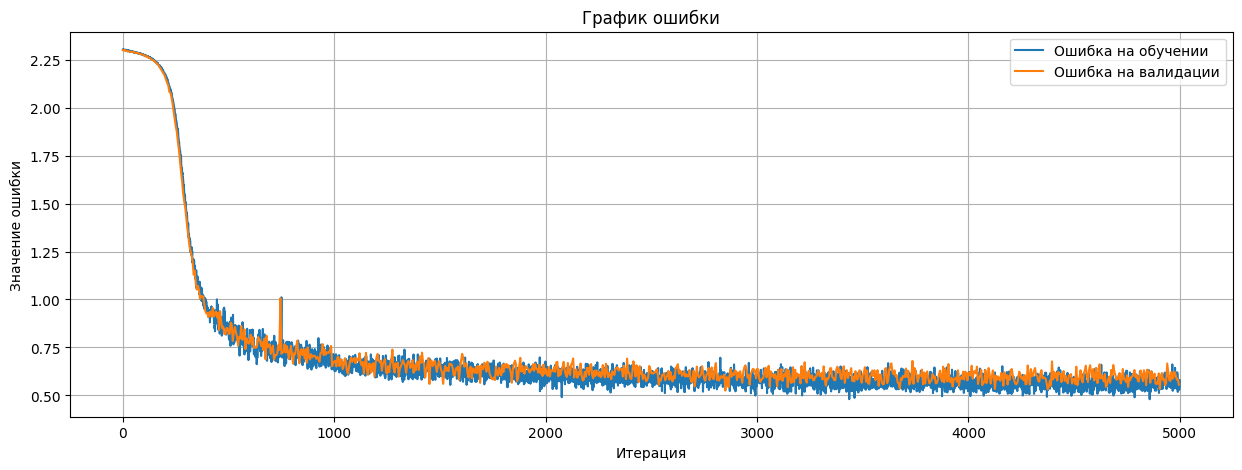

In [ ]:
# Обучение модели
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # Берем случайные batch_size примеров из обучающей выборки.
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])

    # Добавляем предсказания и потери
    pred = model(x_train[batch_pos])  # Прогон модели на обучающих данных
    loss = loss_fn(pred, y_train[batch_pos])

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Каждые val_every итераций считаем значение ошибки на валидационной выборке.
    if epoch % val_every == 0:
        model.eval()
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos])
            val_loss = loss_fn(val_pred, y_val[val_batch_pos])
            losses["val"].append(val_loss.item())

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 5 итераций выводим графики ошибки.
    if epoch % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(15, 5))
        plt.title("График ошибки")
        plt.plot(losses["train"], label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], label="Ошибка на валидации")
        plt.xlabel("Итерация")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid(True)
        plt.show()

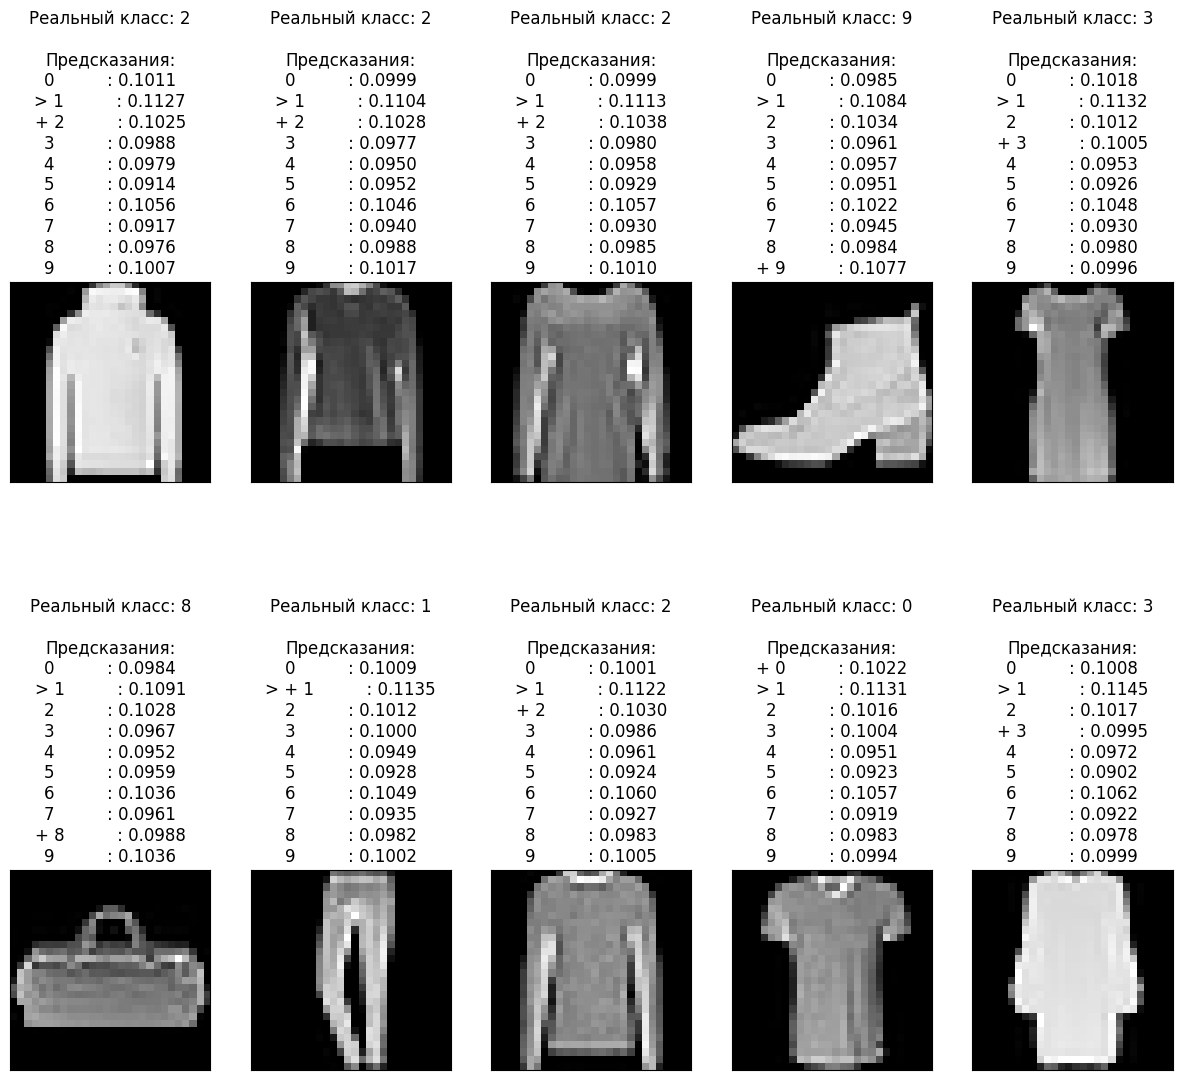

In [ ]:
# Функция для визуализации результатов
def show_results(model, h=2, w=5):
    model.eval()
    with torch.no_grad():
        random_indices = random.sample(range(x_val.shape[0]), h * w)
        batch_probs = torch.softmax(model(x_val[random_indices]), dim=1)

        fig, ax = plt.subplots(h, w, figsize=(15, 7 * h))
        for i in range(h * w):
            plt.subplot(h, w, i + 1)
            img = x_val[random_indices[i]].cpu().numpy().squeeze(0)  # Убираем канал.
            plt.imshow(img, cmap="gray")
            title = f'Реальный класс: {y_val[random_indices[i]].item()}'
            title += '\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {:.4f}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[random_indices[i]] else "+ ",
                    j,
                    prob.item(),
                )
            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

# Показать результаты
show_results(model)